# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

##### Notebook settings

In [46]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

##### Import libraries

In [47]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [48]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

##### Define constants

In [49]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
SPLIT = 0.15
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SIZE = [256, 256] # dataset image size is 299x299
EPOCHS = 20

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

## Data


### Create dataset

In [50]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [51]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [52]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [53]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [54]:
# create train-test split
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=SPLIT, random_state=random_state)

In [55]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [56]:
TRAIN_IMG_COUNT = len(y_train)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7684, Test: 1356


In [57]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4607, 'COVID-19': 3077}
test set:   {'normal': 817, 'COVID-19': 539}


###### Create tensors

In [58]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [59]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [60]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing and data augmentation

In [61]:
preprocessing = tf.keras.Sequential([
  Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  Rescaling(scale=1./255)
])

In [62]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [63]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [64]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare datasets for use

In [65]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [66]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [67]:
# seperate train labels and images for attacks
train_unbatched= prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_train_attack = prepare_dataset(train_unbatched,
                                 pre=False,
                                 shuffle=False,
                                 repeat=False,
                                 batch=1, # TODO batching needed?
                                 augment=False)
y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(train_unbatched):
    y_train_attack.append(y)

# seperate test labels and images for attacks
test_unbatched = prepare_dataset(test_ds,
                                 pre=True,
                                 shuffle=False,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_test_attack = prepare_dataset(test_unbatched,
                                pre=False,
                                shuffle=False,
                                repeat=False,
                                batch=1, # TODO batching needed?
                                augment=False)
y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(test_unbatched):
    y_test_attack.append(y)

### Visualization

###### Distribution of labels in the sets

In [68]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

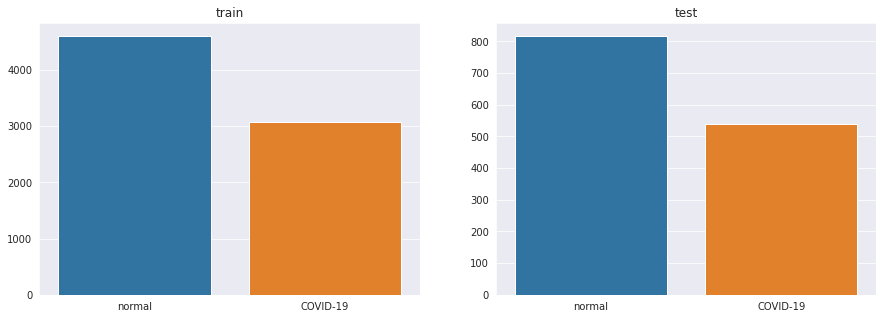

In [69]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [70]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [71]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


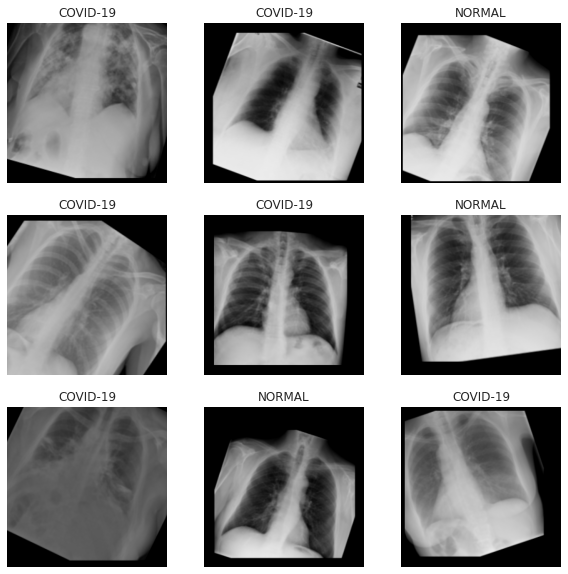

In [72]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [73]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [74]:
learning_rate_decay = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.1, min_lr=1e-6)

## DP-Net - CNN Archecture for DP-SGD
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [75]:
def dpnet_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='relu'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ])
    return dpnet

In [76]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet.compile(
    optimizer=Adam(lr=1e-3), # default: 1e-3
    loss='binary_crossentropy',
    metrics=METRICS
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [77]:
dpnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization_3 (Batch (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7200)             

### Training

In [78]:
history_dpnet = dpnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20
240/240 [==============================] - 115s 463ms/step - loss: 0.6461 - accuracy: 0.6627 - precision: 0.5632 - recall: 0.6953
Epoch 2/20
240/240 [==============================] - 108s 450ms/step - loss: 0.5290 - accuracy: 0.7286 - precision: 0.6424 - recall: 0.7406
Epoch 3/20
240/240 [==============================] - 107s 447ms/step - loss: 0.5143 - accuracy: 0.7414 - precision: 0.6504 - recall: 0.7601
Epoch 4/20
240/240 [==============================] - 108s 446ms/step - loss: 0.4814 - accuracy: 0.7620 - precision: 0.6795 - recall: 0.7819
Epoch 5/20
240/240 [==============================] - 106s 442ms/step - loss: 0.4716 - accuracy: 0.7704 - precision: 0.6901 - recall: 0.7996
Epoch 6/20
240/240 [==============================] - 105s 438ms/step - loss: 0.4338 - accuracy: 0.7973 - precision: 0.7185 - recall: 0.8148
Epoch 7/20
240/240 [==============================] - 105s 437ms/step - loss: 0.4384 - accuracy: 0.7939 - precision: 0.7210 - recall: 0.8103
Epoch 8/20
24

### Evaluation

###### Visualize performance

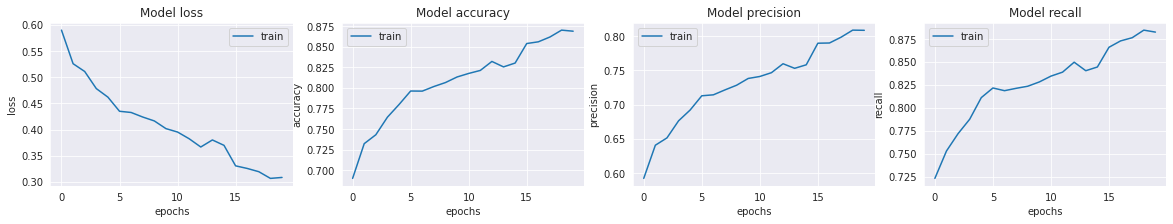

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train'])

###### Predict on test set

batch 32  
Loss of the model is -  0.23561064898967743  
Accuracy of the model is -  90.11799693107605 %  
Precision of the model is -  0.8729282021522522  
Recall of the model is -  0.8794063329696655  

In [80]:
loss, acc, prec, rec = dpnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 4s 76ms/step - loss: 0.2769 - accuracy: 0.8923 - precision: 0.9018 - recall: 0.8182
Loss of the model is -  0.27690330147743225
Accuracy of the model is -  89.23304080963135 %
Precision of the model is -  0.9018405079841614
Recall of the model is -  0.8181818127632141


## Privacy

### Compute epsilon

In [81]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [82]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [83]:
NOISE_MULTIPLIER = 0.0
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = inf


### Attacks

###### Model Inversion Attack

In [84]:
def invert_model(model, max_iter, lr, img, init='random', pred_cutoff= 0.99, disp_freq=1, disp_img=False):
    # expected label
    probs = model.predict(img)[0][0]
    label = np.round(probs)
    # initial inversion image
    if init == 'zero':
        current_x = np.copy(img) # save batching
        current_x[0] = np.zeros(img[0].shape)
    elif init == 'random':
        current_x = np.copy(img) # save batching
        current_x[0] = np.random.rand(img[0].shape[0],
                                   img[0].shape[1],
                                   img[0].shape[2])
    
    current_probs = model.predict(current_x)[0][0]
    
    plt.imshow(current_x[0])
    plt.axis('off')
    plt.title('Initial inversion image')
    plt.show()
    print('Predictions for COVID-19 class: ' + str(current_probs))

    # simple cnn for inversion
    inversion_model = Sequential([
        InputLayer(input_shape=img[0].shape),
        Dense(256, activation="relu"),
        Flatten(),
        Dense(1, activation='sigmoid'),
    ], name='InversionModel')
    optimizer = keras.optimizers.SGD(learning_rate=1e-3)
    loss_fn = BinaryCrossentropy(from_logits=False)

    print('Inversion started...')
    for i in range(1, max_iter+1):
        # get gradients and loss for current image
        with tf.GradientTape(persistent=False) as tape:
            x = tf.convert_to_tensor(current_x)
            tape.watch(x)
            logits = model(x, training=False)
            tape.watch(logits)
            loss = loss_fn(np.array([[label]]), logits)
            tape.watch(loss)
            gradient = tape.gradient(loss, x)
            grads = gradient

        # update current image
        current_x[0] = current_x[0] - lr * grads[0] # + or - ?
        current_x[0] = np.clip(current_x[0], 0.0, 1.0)
        #current_x[0] = current_x[0] * 1./255.
        
        current_probs = model.predict(current_x)[0][0]
        #cost = tf.abs(tf.subtract(label, current_probs))
        
        if pred_cutoff < current_probs:
            print("\n Above Probability Criteria!: {0}".format(current_probs))
            break
            
        if i%disp_freq ==0:
            if disp_img == True:
                plt.imshow(current_x[0])
                plt.axis('off')
                plt.title('Iteration %i' % (i))
                plt.show()
            print("\r Iteration %i - Probs: %.2f and Loss: %.4f" % (i, current_probs, loss))
          
    print('Inversion finished.')
    return current_x, current_probs

In [85]:
def perform_inversion(model, img, label):
    # original
    plt.imshow(img[0])
    plt.axis('off')
    if label[0] == 0:
        plt.title("Original image (NORMAL)")
    elif label[0] == 1:
        plt.title("Original image (COVID-19)")
    plt.show()
    print('Predictions for COVID-19 class: ' + str((model.predict(img))[0][0]))
    
    # inverse
    inv_img, inv_img_probs = invert_model(model, 
                                          max_iter=100, 
                                          lr=3, 
                                          img=img,
                                          init='random',
                                          disp_freq=25,
                                          disp_img=True)

    plt.imshow(inv_img[0])
    plt.axis('off')
    plt.title('Inversion image')
    plt.show()
    print('Predictions for COVID-19 class: ' + str(inv_img_probs))

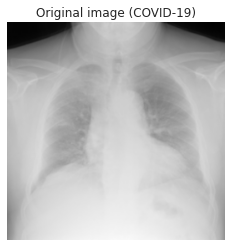

Predictions for COVID-19 class: 0.9211857


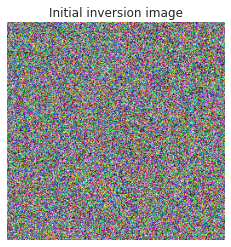

Predictions for COVID-19 class: 0.8900225
Inversion started...

 Above Probability Criteria!: 0.9903804063796997
Inversion finished.


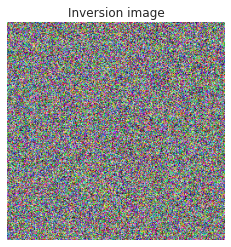

Predictions for COVID-19 class: 0.9903804


In [86]:
# use x_test_attack for batch size 1
for i, ex in enumerate(iter(x_test_attack)):
    if i == 1:
        break
    image_batch, label_batch = ex
    perform_inversion(dpnet, image_batch.numpy(), label_batch.numpy())

###### Membership Inference Attack

In [87]:
!pip install tensorflow-privacy

In [88]:
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia

In [89]:
print('Predict on train...')
probs_train = dpnet.predict(x_train_attack)
print('Predict on test...')
probs_test = dpnet.predict(x_test_attack)

# only label as output instead of prob
#probs_train = np.round(logits_train)
#probs_test = np.round(logits_test)


print('Compute losses...')
bc = tf.keras.backend.binary_crossentropy
constant = tf.keras.backend.constant

loss_train = np.array([x[0] for x in bc(constant([[y] for y in y_train_attack]), constant(probs_train), from_logits=False).numpy()])
loss_test = np.array([x[0] for x in bc(constant([[y] for y in y_test_attack]), constant(probs_test), from_logits=False).numpy()])

train_labels = np.array(y_train_attack)
test_labels = np.array(y_test_attack)

Predict on train...
Predict on test...
Compute losses...


Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.83 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.55 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 1356 training and 1356 test examples) achieved an AUC of 0.72
  LOGISTIC_REGRESSION (with 1356 training and 1356 test examples) achieved an advantage of 0.43

Best-perf

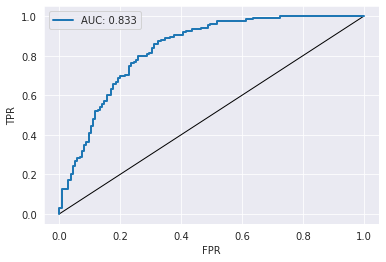

In [90]:
attack_input = AttackInputData(
  logits_train = probs_train,
  logits_test = probs_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
] 

# Run several attacks for different data slices
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

# Plot the ROC curve of the best classifier
plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices=True))